In [53]:
import torch
import numpy
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
def f(x):
  return 1/(1+25*(x**2))

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, device, dtype = torch.float32):
        self._X = torch.tensor(X, device = device, dtype = dtype).reshape(-1, 1)
        self._Y = torch.tensor(Y, device = device, dtype = dtype).reshape(-1, 1)
    def __len__(self):
        return len(self._X)
    def __getitem__(self, idx):
        return self._X[idx], self._Y[idx]

In [55]:
def dfdx(x):
  return -50 * x / ((1 + 25 * (x**2))**2)

In [56]:
X_train=torch.linspace(-1,1,1000)
Y_train=f(X_train)
X_test=torch.linspace(-1,1,200)
Y_test=f(X_test)
train_ds = Dataset(X_train, Y_train, device)
test_ds = Dataset(X_test, Y_test, device)

/tmp/ipython-input-1389271390.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._X = torch.tensor(X, device = device, dtype = dtype).reshape(-1, 1)
/tmp/ipython-input-1389271390.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._Y = torch.tensor(Y, device = device, dtype = dtype).reshape(-1, 1)


In [57]:
dY_train = dfdx(X_train).to(device=device, dtype=torch.float32)
dY_test = dfdx(X_test).to(device=device, dtype=torch.float32)

train_ds_prime = Dataset(X_train, dY_train, device)
test_ds_prime = Dataset(X_test, dY_test, device)

/tmp/ipython-input-1389271390.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._X = torch.tensor(X, device = device, dtype = dtype).reshape(-1, 1)
/tmp/ipython-input-1389271390.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._Y = torch.tensor(Y, device = device, dtype = dtype).reshape(-1, 1)


In [58]:
def combined_loss(y_predicted, y_true, y_prime_predicted, y_prime_true):
    function_loss = torch.nn.functional.mse_loss(y_predicted, y_true)
    derivative_loss = torch.nn.functional.mse_loss(y_prime_predicted, y_prime_true)
    return function_loss + derivative_loss

In [59]:
import torch.nn as nn
import torch.nn.functional

class YourModel(torch.nn.Module):
    def __init__(self, device, dtype = torch.float32):
        super().__init__()
        self.W = torch.nn.Linear(1, 7, device=device, dtype=dtype)
        self.T = torch.nn.Tanh()
        self.U = torch.nn.Linear(7, 7, device=device, dtype=dtype)
        self.G = torch.nn.Tanh()
        self.V = torch.nn.Linear(7, 1, device=device, dtype=dtype)


    def forward(self, _x):
        _x.requires_grad_(True)
        _w = self.W(_x)
        _t = self.T(_w)
        _u = self.U(_t)
        _g = self.G(_u)
        _y = self.V(_g)
        _y_prime = torch.autograd.grad(_y, _x, grad_outputs=torch.ones_like(_y), create_graph=True)[0]
        return _y, _y_prime

In [60]:
model = YourModel(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
n_epoch = 2000
losses = []

for i in range(n_epoch):
    optimizer.zero_grad()
    _y_prediction, _y_prime_prediction = model(train_ds._X)
    loss = combined_loss(_y_prediction, train_ds._Y, _y_prime_prediction, train_ds_prime._Y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if i % 200 == 0:
        print(f"Epoch {i}, Loss={loss.item():.6e}")

Epoch 0, Loss=2.049288e+00
Epoch 200, Loss=6.452787e-04
Epoch 400, Loss=1.161076e-04
Epoch 600, Loss=2.057592e-05
Epoch 800, Loss=5.716002e-06
Epoch 1000, Loss=3.754574e-06
Epoch 1200, Loss=3.483690e-06
Epoch 1400, Loss=4.740015e-06
Epoch 1600, Loss=1.292371e-04
Epoch 1800, Loss=2.513629e-06


In [61]:
_y_outcome_prediction, _y_prime_outcome_prediction = model(test_ds._X)
function_loss = torch.nn.functional.mse_loss(_y_outcome_prediction, test_ds._Y)
print("Test Function Loss:", function_loss.item())
derivative_loss = torch.nn.functional.mse_loss(_y_prime_outcome_prediction, test_ds_prime._Y)
print("Test Derivative Loss:", derivative_loss.item())

Test Function Loss: 9.583808413538009e-09
Test Derivative Loss: 2.28495287046826e-06


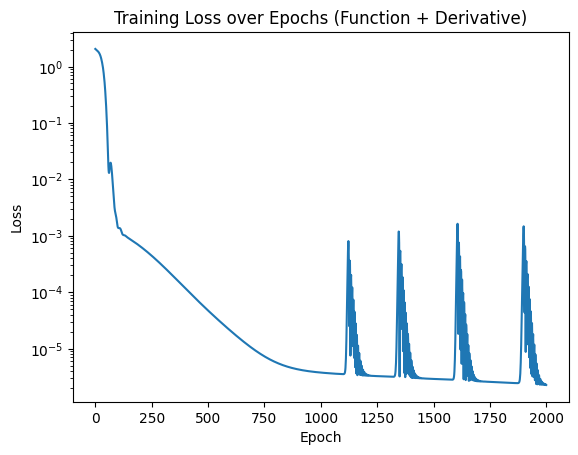

In [62]:
plt.figure()
plt.plot(range(n_epoch), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs (Function + Derivative)")
plt.yscale("log")
plt.show()

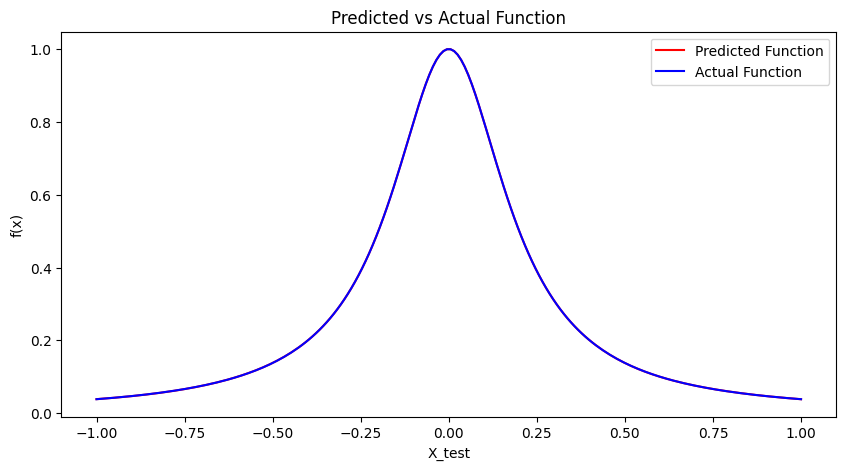

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(test_ds._X.cpu().detach().numpy(),
    _y_outcome_prediction.cpu().detach().numpy(),
    label="Predicted Function",
    color="red",)
plt.plot(test_ds._X.cpu().detach().numpy(),
    test_ds._Y.cpu().numpy(),
    label="Actual Function",
    color="blue",)
plt.xlabel("X_test")
plt.ylabel("f(x)")
plt.title("Predicted vs Actual Function")
plt.legend()
plt.show()

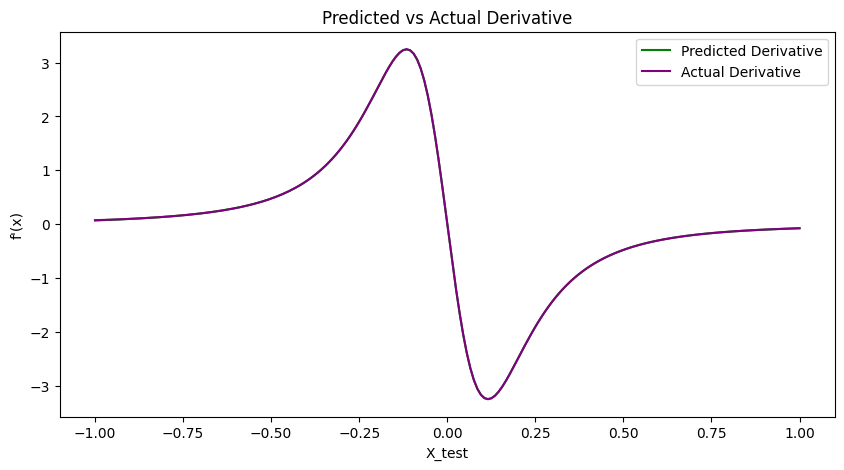

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(test_ds._X.cpu().detach().numpy(),
    _y_prime_outcome_prediction.cpu().detach().numpy(),
    label="Predicted Derivative",
    color="green",)
plt.plot(test_ds_prime._X.cpu().detach().numpy(),
    test_ds_prime._Y.cpu().numpy(),
    label="Actual Derivative",
    color="purple",)
plt.xlabel("X_test")
plt.ylabel("f'(x)")
plt.title("Predicted vs Actual Derivative")
plt.legend()
plt.show()